In [1]:
# Putting the initialisation at the top now!
import veneer
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

v = veneer.Veneer(port=9876)

# Session 6 - Model Setup and Reconfiguration

This session covers functionality in Veneer and veneer-py for making larger changes to model setup, including structural changes.

Using this functionality, it is possible to:

* Create (and remove) nodes and links
* Change model algorithms, such as changing links from Straight Through Routing to Storage Routing
* Assign input time series to model variables
* Query and modify parameters across similar nodes/links/catchments/functional-units

## Overview

- (This is a Big topic)
- Strengths and limitations of configuring from outside
  - +ve repeatability
  - +ve clarity around common elements - e.g. do one thing everywhere, parameterised by spatial data
  - -ve feedback - need to query the system to find out what you need to do vs a GUI that displays it
- Obvious and compelling use cases (worked examples)
  - Catchments: Applying a constituent model everywhere and assigning parameters using spatial data
  - Catchments: Climate data
- How it works:
  - The Python <-> IronPython bridge
  - What’s happening under the hood
  - Layers of helper functions
  - How to discover parameters
- Harder examples (not fully worked)
  - Creating and configuring a storage from scratch
- Extending the system


**Note:** This session uses `ExampleProject/RiverModel2.rsproj`. You are welcome to work with your own model instead, however you will need to change the notebook text at certain points to reflect the names of nodes, links and functions in your model file.


## Warning: Big Topic

This is a big topic and the material in this session will only touch on some of the possibilities.

Furthermore, its an evolving area - so while there is general purpose functionality that is quite stable, making the functionality easy to use for particular tasks is a case by case basis that has been tackled on an as-needed basis. **There are lots of gaps!**

## Motivations, Strengths and Limitations of Scripting configuration

There are various motivations for the type of automation of Source model setup described here. Some of these motivations are more practical to achieve than others!

### Automatically build a model from scratch, using an executable 'recipe'

Could you build a complete Source model from scratch using a script?

In theory, yes you could. However it is not practical at this point in time using Veneer. (Though the idea of building a catchments-style model is more foreseeable than building a complex river model).

For some people, building a model from script would be desirable as it would have some similarities to configuring models in text files as was done with the previous generation of river models. A script would be more powerful though, because it has the ability to bring in adhoc data sources (GIS layers, CSV files, etc) to define the model structure. The scripting approach presented here wouldn't be the most convenient way to describe a model node-by-node, link-by-link - it would be quite cumbersome. However it would be possible to build a domain-specific language for describing models that makes use of the Python scripting.

### Automate bulk changes to a model

Most of the practical examples to date have involved applying some change across a model (whether that model is a catchments-style geographic model or a schematic style network). Examples include:

* **Apply a new constituent generation model:** A new generation model was being tested and needed to be applied to every catchment in the model. Some of the parameters would subsequently be calibrated (using PEST), but others needed to be derived from spatial data.
* **Add and configure nodes for point source inputs:** A series of point sources needed to be represented in the models. This involved adding inflow nodes for each point source, connecting those inflows to the most appropriate (and available) downstream node and computing and configuring time series inputs for the inflows.
* **Bulk rename nodes and links based on a CSV file:** A complex model needed a large number of nodes and links renamed to introduce naming conventions that would allow automatic post-processing and visualisation. A CSV was created with old node/link names (extracted from Source using veneer-py). A second column in the CSV was then populated (by hand) with new node/link names. This CSV file was read into Python and used to apply new names to affected nodes/links.

### Change multiple models in a consistent way

* **Testing a plugin in multiple catchments:** A new plugin model was being tested across multiple catchments models, including calibration. A notebook was written to apply the plugin to a running Source model, parameterise the plugin and configure PEST. This notebook was then applied to each distinct Source model in turn.

### Change a model without making the changes permanent

There are several reasons for making changes to the Source model without wanting the changes to be permanently saved in the model.

1. Testing an alternative setup, such as a different set of routing parameters. Automating the application of new parameters means you can test, and then re-test at a later date, without needing manual rework.
2. Maintaining a single point-of-truth for a core model that needs to support different purposes and users.
3. Persistence not available. In the earlier examples of testing new plugin models, the automated application of model setup allowed sophisticated testing, including calibration by PEST, to take place before the plugin was stable enough to be persisted using the Source data management system.


## Example - Switching routing methods and configuring

This example uses the earlier `RiverModel.rsproj` example file although it will work with other models.

Here, we will convert all links to use Storage Routing except for links that lead to a water user.

**Note:** To work through this example (and the others that follow), you will need to ensure the 'Allow Scripts' option is enabled in the Web Server Monitoring window.

### The `v.model` namepsace

Most of our work in this session will involve the `v.model` namespace. This namespace contains functionality that provides query and modification of the model structure. Everything in `v.model` relies on the 'Allow Scripts' option.

As with other parts of veneer-py (and Python packages in general), you can use `<tab>` completion to explore the available functions and the `help()` function (or the `?` suffix) to get help.

### Finding the current routing type

We can use `v.model.link.routing.get_models()` to find the routing models used on each link

In [2]:
existing_models = v.model.link.routing.get_models()
existing_models

['RiverSystem.Flow.StraightThroughRouting',
 'RiverSystem.Flow.StraightThroughRouting',
 'RiverSystem.Flow.LaggedFlowRoutingWrapper',
 'RiverSystem.Flow.StraightThroughRouting',
 'RiverSystem.Flow.StraightThroughRouting',
 'RiverSystem.Flow.StraightThroughRouting',
 'RiverSystem.Flow.StraightThroughRouting',
 'RiverSystem.Flow.StraightThroughRouting',
 'RiverSystem.Flow.StraightThroughRouting',
 'RiverSystem.Flow.StraightThroughRouting',
 'RiverSystem.Flow.StraightThroughRouting']

**Note:**

* The `get_models()` functions is available in various places through the `v.model` namespace. For example, `v.model.catchments.runoff.get_models()` queries the rainfall runoff models in subcatchments (actually in functional units). There are other such methods, available in multiple places, including:
  * `set_models`
  * `get_param_values`
  * `set_param_values`
* Each of these functions accept parameters to restrict the search, such as only including links with certain names. These query parameters differ in different contexts (ie between runoff models and routing models), but they are consistent between the functions in a given context. Confused?
* For example, in link routing you can look for links of certain names and you can do this with the different methods:
```python
v.model.link.routing.get_models(links='Default Link #3')
v.model.link.routing.set_models('RiverSystem.Flow.LaggedFlowRoutingWrapper',links='Default Link #3')
```
Whereas, with runoff models, you can restrict by catchment or by fus:
```python
v.model.catchment.runoff.get_models(fus='Grazing')
v.model.catchment.runoff.set_models('MyFancyRunoffModel',fus='Grazing')
```
* You can find out what query parameters are available by looking at the help, one level up:
```python
help(v.model.link.routing)
```
* The call to `get_models()` return a list of model names. Two observations about this:
  1. The model name is the fully qualified class name as used internally in Source. This is a common pattern through the `v.model` namespace - it uses the terminology within Source. There are, however, help functions for finding what you need. For example:
  ```python
  v.model.find_model_type('gr4')
  v.model.find_parameters('RiverSystem.Flow.LaggedFlowRoutingWrapper')
  ```
  2. Returning a list doesn't tell you which link has which model - so how are you going to determine which ones should be Storage Routing and which should stay as Straight Through? In general the `get_` functions return lists (although there is a `by_name` option being implemented) and the `set_` functions accept lists (unless you provide a single value in which case it is applied uniformly). It is up to you to interpret the lists returned by `get_*` and to provide `set_*` with a list in the right order. The way to get it right is to separately query for the _names_ of the relevant elements (nodes/links/catchments) and order accordingly. This will be demonstrated!

### Identifying which link should stay as StraightThroughRouting

We can ask for the names of each link in order to establish which ones should be Storage Routing and which should stay as Straight Through

In [3]:
link_names_order = v.model.link.routing.names()
link_names_order

['Default Link #1',
 'Default Link #2',
 'Default Link #3',
 'Default Link #4',
 'Default Link #5',
 'Default Link #6',
 'Lake Outflow',
 'Default Link #13',
 'Default Link #14',
 'Default Link #15',
 'Default Link #11']

OK - that gives us the names - but it doesn't help directly. We could look at the model in Source to
work out which one is connected to the Water User - but that's cheating!

More generally, we can ask Veneer for the network and perform a topological query

In [4]:
network = v.network()

Now that we've got the network, we want all the water users.

Now, the information we've been returned regarding the network is in GeoJSON format and is intended for use in visualisation. It doesn't explicitly say 'this is a water user' at any point, but it does tell us indirectly tell us this by telling us about the icon in use:

In [5]:
network['features']._unique_values('icon')


{'/resources/InjectedFlow',
 '/resources/ExtractionNodeModel',
 '/resources/WaterUserNodeModel',
 '/resources/GaugeNodeModel',
 '/resources/ConfluenceNodeModel',
 '/resources/MinimumFlowConstraintModel',
 None,
 '/resources/StorageNodeModel'}

So, we can find all the water users in the network, by finding all the network features with `'/resources/WaterUserNodeModel'` as their icon!

In [6]:
water_users = network['features'].find_by_icon('/resources/WaterUserNodeModel')
water_users

[{'type': 'Feature', 'properties': {'schematic_location': [329, 617], 'icon': '/resources/WaterUserNodeModel', 'name': 'Crop Fields', 'feature_type': 'node'}, 'id': '/network/nodes/94', 'geometry': {'type': 'Point', 'coordinates': [0, 0]}}]

Now, we can query the network for links upstream of each water user.

We'll loop over the `water_users` list (just one in the sample model)

In [7]:
links_upstream_of_water_users=[]
for water_user in water_users:
    links_upstream_of_water_users += network.upstream_links(water_user)
links_upstream_of_water_users

[{'geometry': {'coordinates': [[0, 0], [0, 0]], 'type': 'LineString'},
  'id': '/network/link/7',
  'properties': {'feature_type': 'link',
   'from_node': '/network/nodes/90',
   'name': 'Default Link #13',
   'to_node': '/network/nodes/94'},
  'type': 'Feature'}]

Just one link (to be expected) in the sample model. Its the name we care about though:

In [8]:
names_of_water_user_links = [link['properties']['name'] for link in links_upstream_of_water_users]
names_of_water_user_links

['Default Link #13']

To recap, we now have:

* `existing_models` - A list of routing models used on links
* `link_names_order` - The name of each link, in the same order as for `existing_models`
* `names_of_water_user_links` - The names of links immediately upstream of water users. These links need to stay as Straight Through Routing

We're ultimately going to call

```python
v.model.link.routing.set_models(new_models,fromList=True)
```

so we need to construct `new_models`, which will be a list of model names to assign to links, with the right mix and order of storage routing and straight through. We'll want `new_models` to be the same length as `existing_models` so there is one entry per link. (There are cases where you my use `set_models` or `set_param_values` with shorter lists. You'll get R-style 'recycling' of values, but its more useful in catchments where you're iterating over catchments AND functional units)

The entries in `new_models` need to be strings - those long, fully qualified class names from the Source world. We can find them using `v.model.find_model_type`

In [9]:
v.model.find_model_type('StorageRo')

['RiverSystem.Flow.StorageRouting']

In [10]:
v.model.find_model_type('StraightThrough')

['RiverSystem.Flow.StraightThroughRouting']

We can construct our list using a list comprehension, this time with a bit of extra conditional logic thrown in

In [11]:
new_models = ['RiverSystem.Flow.StraightThroughRouting' if link_name in names_of_water_user_links
              else 'RiverSystem.Flow.StorageRouting'
              for link_name in link_names_order]
new_models

['RiverSystem.Flow.StorageRouting',
 'RiverSystem.Flow.StorageRouting',
 'RiverSystem.Flow.StorageRouting',
 'RiverSystem.Flow.StorageRouting',
 'RiverSystem.Flow.StorageRouting',
 'RiverSystem.Flow.StorageRouting',
 'RiverSystem.Flow.StorageRouting',
 'RiverSystem.Flow.StraightThroughRouting',
 'RiverSystem.Flow.StorageRouting',
 'RiverSystem.Flow.StorageRouting',
 'RiverSystem.Flow.StorageRouting']

This is a more complex list comprehension than we've used before. It goes like this, reading from the end:

* Iterate over all the link names. This will be the right number of elements - and it tells us which link we're dealling with
```python
 for link_name in link_names_order]
```
* If the current `link_name` is present in the list of links upstream of water users, use straight through routing
```python
['RiverSystem.Flow.StraightThroughRouting' if link_name in names_of_water_user_links
```
* Otherwise use storage routing
```python
 else 'RiverSystem.Flow.StorageRouting'
```

All that's left is to apply this to the model

In [12]:
v.model.link.routing.set_models(new_models,fromList=True)

True

**Notes:**

* Source uses different line styles for different routing types - but it might not redraw until you prompt it - eg by resizing the window
* The `fromList` parameter tells the `set_models` function that you want the list to be applied one element at a time.

Now that you have Storage Routing used in most links, you can start to parameterise the links from the script.

To do so, you could use an input set, as per the previous session. To change parameters via input sets, you would first need to know the wording to use in the input set commands - and at this stage you need to find that wording in the Source user interface.

Alternatively, you can set the parameters directly using `v.model.link.routing.set_param_values`, which expects the variable name as used internally by Source. You can query for the parameter names for a particular model, using `v.model.find_parameters(model_type)` and, if that doesn't work `v.model.find_properties(model_type)`.

We'll start by using `find_parameters`:

In [13]:
v.model.find_parameters('RiverSystem.Flow.StorageRouting')

['InflowBias',
 'LossGainFlux',
 'NetEvaporation',
 'RoutingConstant',
 'RoutingPower',
 'TimeSeriesFlux']

The function `v.model.find_parameters`, accepts a model type (actually, you can give it a list of model types) and it returns a list of parameters.

This list is determined by the internal code of Source - a parameter will only be returned if it has a `[Parameter]` tag in the C\# code.

From the list above, we see some parameters that we expect to see, but not all of the parameters for a Storage Routing reach. For example, the list of parameters doesn't seem to say how we'd switch from Generic to Piecewise routing mode. This is because the model property in question (`IsGeneric`) doesn't have a `[Property]` attribute.

We can find a list of all fields and properties of the model using `v.model.find_properties`. It's a lot more information, but it can be helpful:

In [14]:
v.model.find_properties('RiverSystem.Flow.StorageRouting')

{'AllowDeactivation': 'Boolean',
 'AverageRegFlow': 'Double',
 'Divisions': 'Int32',
 'DownstreamFlow': 'Double',
 'Inflow': 'Double',
 'InflowBias': 'Double',
 'InitFlow': 'Double',
 'InitStorage': 'Double',
 'IsGeneric': 'Boolean',
 'IsInitFlow': 'Boolean',
 'LateralInflow': 'Double',
 'LiveStorage': 'Double',
 'LossGainFlux': 'Double',
 'LossReports': 'List`1',
 'MappedTravelTime': 'Int32',
 'Name': 'String',
 'NetEvaporation': 'Double',
 'ObserverCount': 'Int32',
 'Observers': 'IList`1',
 'Outflow': 'Double',
 'OutflowVolumeOverridden': 'Boolean',
 'Piecewises': 'IList`1',
 'PreOverrideOutflowVolume': 'Double',
 'PreOverrideStorageVolume': 'Double',
 'PreviousInflow': 'Double',
 'PreviousLateralInflow': 'Double',
 'PreviousOutflow': 'Double',
 'PreviousStorage': 'Double',
 'ReachLength': 'Double',
 'RoutingConstant': 'Double',
 'RoutingPower': 'Double',
 'Storage': 'Double',
 'StorageAtStartOfTs': 'Double',
 'StorageRoutingName': 'String',
 'StorageVolumeOverridden': 'Boolean',
 'T

Lets apply an initial parameter set to every Storage Routing link by setting:

* `RoutingConstant` to 86400, and
* `RoutingPower` to 1

We will call `set_param_values`

In [15]:
help(v.model.link.routing.set_param_values)

Help on method set_param_values in module veneer.server_side:

set_param_values(parameter, values, literal=False, fromList=False, instantiate=False, **kwargs) method of veneer.server_side.VeneerLinkRoutingActions instance
    Set the values of a particular parameter used in a particular context



In [16]:
v.model.link.routing.set_param_values('RoutingConstant',86400.0)

True

In [17]:
v.model.link.routing.set_param_values('RoutingPower',1.0)

True

You can check in the Source user interface to see that the parameters have been applied

### Setting parameters as a function of other values

Often, you will want to calculate model parameters based on some other information, either within the model or from some external data source.

The `set_param_values` can accept a list of values, where each item in the list is applied, in turn, to the corresponding models - in much the same way that we used the known link order to set the routing type.

The list of values can be computed in your Python script based on any available information. A common use case is to compute catchment or functional unit parameters based on spatial data.

We will demonstrate the list functionality here with a contrived example!

We will set a different value of `RoutingPower` for each link. We will compute a different value of `RoutingPower` from 1.0 down to >0, based on the number of storage routing links

In [23]:
number_of_links = len(new_models) - len(names_of_water_user_links)

In [29]:
power_vals = np.arange(1.0,0.0,-1.0/number_of_links)
power_vals

array([ 1. ,  0.9,  0.8,  0.7,  0.6,  0.5,  0.4,  0.3,  0.2,  0.1])

In [30]:
v.model.link.routing.set_param_values('RoutingPower',power_vals,fromList=True)

True

If you open the Feature Table for storage routing, you'll now see these values propagated.

The `fromList` option has another characteristic that can be useful - particularly for catchments models with multiple functional units: value recycling.

If you provide a list with few values than are required, the system will start again from the start of the list.

So, for example, the following code will assign the three values: `[0.5,0.75,1.0]`

In [28]:
v.model.link.routing.set_param_values('RoutingPower',[0.5,0.75,1.0],fromList=True)

True

Check the Feature Table to see the effect.

**Note:** You can run these scripts with the Feature Table open and the model will be updated - but the feature table won't reflect the new values until you Cancel the feature table and reopen it.

## How it Works

As mentioned, everything under `v.model` works by sending an IronPython script to Source to be run within the Source software itself.

IronPython is a native, .NET, version of Python and hence can access all the classes and objects that make up Source.

When you call a function witnin `v.model`, veneer-py is *generating* an IronPython script for Source. 

To this point, we haven't seen what these IronPython scripts look like - they are hidden from view. We can see the scripts that get sent to Source by setting the option `veneer.general.PRINT_SCRIPTS=True`


In [47]:
veneer.general.PRINT_SCRIPTS=True
v.model.link.routing.get_models(links=['Default Link #3','Default Link #4'])

# Generated Script
import clr
import System
import FlowMatters.Source.Veneer.RemoteScripting.ScriptHelpers as H
clr.ImportExtensions(System.Linq)
result = []
have_succeeded = False
ignoreExceptions = True
for i_0 in scenario.Network.Links.Where(lambda l:l.DisplayName in ['Default Link #3', 'Default Link #4']):
    try:
        result.append(i_0.FlowRouting.GetType().FullName)
        have_succeeded = True
    except:
      if not ignoreExceptions: raise



['RiverSystem.Flow.StorageRouting', 'RiverSystem.Flow.StorageRouting']

In [48]:
veneer.general.PRINT_SCRIPTS=False

*Writing these IronPython scripts from scratch requires an understanding of the internal data structures of Source. The functions under `v.model` are designed to shield you from these details.*

That said, if you have an idea of the data structures, you may wish to try writing IronPython scripts, OR, try working with some of the lower-level functionality offered in `v.model`.

Most of the `v.model` functions that we've used, are ultimately based upon two, low level thems:

* `v.model.get` and
* `v.model.set`

Both `get` and `set` expect a query to perform on a Source scenario object. Structuring this query is where an understanding of Source data structures comes in.

For example, the following query will return the number of nodes in the network. (We'll use the PRINT_SCRIPTS option to show how the query translates to a script):

In [49]:
veneer.general.PRINT_SCRIPTS=True
num_nodes = v.model.get('scenario.Network.Nodes.Count()')
num_nodes

# Generated Script
import clr
import System
import FlowMatters.Source.Veneer.RemoteScripting.ScriptHelpers as H
clr.ImportExtensions(System.Linq)
result = scenario.Network.Nodes.Count()



12

The follow example returns the names of each node in the network. The `.*` notation tells veneer-py to loop over every element in a collection

In [56]:
node_names = v.model.get('scenario.Network.Nodes.*Name')
node_names

# Generated Script
import clr
import System
import FlowMatters.Source.Veneer.RemoteScripting.ScriptHelpers as H
clr.ImportExtensions(System.Linq)
result = []
have_succeeded = False
ignoreExceptions = True
for i_0 in scenario.Network.Nodes:
    try:
        result.append(i_0.Name)
        have_succeeded = True
    except:
      if not ignoreExceptions: raise



['Crab Creek',
 'Fish Creek',
 'Fish Creek Confluence',
 'Shell Creek',
 'Middle Gauge',
 'Shell Creek Confluence',
 'Lower Gauge',
 'Evaluation Gauge',
 'Recreational Lake',
 'Lake Release',
 'Supply Point 13',
 'Crop Fields']

You can see from the script output that veneer-py has generated a Python for loop to iterate over the nodes:

```python
for i_0 in scenario.Network.Nodes:
```

There are other characteristics in there, such as ignoring exceptions - this is a common default used in `v.model` to silently skip nodes/links/catchments/etc that don't have a particular property.

The same query approach can work for `set`, which can set a particular property (on one or more objects) to a particular value (which can be the same value everywhere, or drawn from a list)

In [60]:
# Generate a new name for each node (based on num_nodes)
names = ['New Name %d'%i for i in range(num_nodes)]
names

['New Name 0',
 'New Name 1',
 'New Name 2',
 'New Name 3',
 'New Name 4',
 'New Name 5',
 'New Name 6',
 'New Name 7',
 'New Name 8',
 'New Name 9',
 'New Name 10',
 'New Name 11']

In [61]:
v.model.set('scenario.Network.Nodes.*Name',names,fromList=True,literal=True)

# Generated Script
import clr
import System
import FlowMatters.Source.Veneer.RemoteScripting.ScriptHelpers as H
clr.ImportExtensions(System.Linq)
origNewVal = ['New Name 0','New Name 1','New Name 2','New Name 3','New Name 4','New Name 5','New Name 6','New Name 7','New Name 8','New Name 9','New Name 10','New Name 11']
origNewVal.reverse()
newVal = origNewVal[:]
have_succeeded = False
ignoreExceptions = True
for i_0 in scenario.Network.Nodes:
    try:
        ignoreExceptions = True
        checkValueExists = i_0.Name
        ignoreExceptions = False
        i_0.Name = newVal.pop()
        if len(newVal)==0: newVal = origNewVal[:]
        
        have_succeeded = True
    except:
      if not ignoreExceptions: raise
result = have_succeeded



True

If you look at the Source model now (you may need to trigger a redraw by resizing the window), all the nodes have been renamed.

(Lets reset the names - note how we saved `node_names` earlier on!)

In [62]:
v.model.set('scenario.Network.Nodes.*Name',node_names,fromList=True,literal=True)

# Generated Script
import clr
import System
import FlowMatters.Source.Veneer.RemoteScripting.ScriptHelpers as H
clr.ImportExtensions(System.Linq)
origNewVal = ['Crab Creek','Fish Creek','Fish Creek Confluence','Shell Creek','Middle Gauge','Shell Creek Confluence','Lower Gauge','Evaluation Gauge','Recreational Lake','Lake Release','Supply Point 13','Crop Fields']
origNewVal.reverse()
newVal = origNewVal[:]
have_succeeded = False
ignoreExceptions = True
for i_0 in scenario.Network.Nodes:
    try:
        ignoreExceptions = True
        checkValueExists = i_0.Name
        ignoreExceptions = False
        i_0.Name = newVal.pop()
        if len(newVal)==0: newVal = origNewVal[:]
        
        have_succeeded = True
    except:
      if not ignoreExceptions: raise
result = have_succeeded



True

**Note:** The `literal=True` option is currently necessary setting text properties using `v.model.set`. This tells the IronPython generator to wrap the strings in quotes in the final script. Otherwise, IronPython would be looking for symbols (eg classes) with the same names

The examples of `v.model.get` and `v.model.set` illustrate some of the low level functionality for manipulating the source model.

The earlier, high-level, functions (eg `v.model.link.routing.set_param_values`) take care of computing the query string for you, including context dependent code such as searching for links of a particular name, or nodes of a particular type. They then call the lower level functions, which takes care of generating the actual IronPython script.

The `v.model` namespace is gradually expanding with new capabilities and functions - but at their essence, most new functions provide a high level wrapper, around `v.model.get` and `v.model.set` for some new area of the Source data structures. So, for example, you could envisage a `v.model.resource_assessment` which provides high level wrappers around resource assessment functionality.


### Exploring the system

Writing the high level wrappers (as with writing the query strings for `v.model.get/set`) requires an understanding of the internal data structures of Source. You can get this from the C# code for Source, or, to a degree, from a help function `v.model.sourceHelp`.

Lets say you want to discover how to change the description of the scenario (say, to automatically add a note about the changes made by your script)

Start, by asking for help on `'scenario'` and explore from there

In [5]:
veneer.general.PRINT_SCRIPTS=False
v.model.sourceHelp('scenario')

['AddConfiguration',
 'AllPluginDataModels',
 'AuxiliaryInformation',
 'AvailableDateRanges',
 'BoundariesForCatchments',
 'BoundaryForCatchment',
 'CatchmentForBoundary',
 'CompareTo',
 'ContainsName',
 'CreateContainer',
 'CropStore',
 'CrossSections',
 'CurrentConfiguration',
 'CurrentRiverSystemConfiguration',
 'DEM',
 'DefaultNodeAngle',
 'DefaultScenarioView',
 'Description',
 'DescriptionChanged',
 'DisplayGrid',
 'Dispose',
 'Equals',
 'FU_CATEGORIES',
 'FU_MAP',
 'FU_POLYGONS',
 'FeatureProxy',
 'GaugeLocationLookup',
 'GeographicData',
 'GetAutoName',
 'GetCurrentRunConfiguration',
 'GetHashCode',
 'GetPluginModel',
 'GetScenarioConfiguration',
 'GetScenarioContainer',
 'GetType',
 'GetUniqueName',
 'GridSize',
 'INTERSECTED_FU_POLYGONS',
 'INTERSECTED_SCFU_POLYGONS',
 'INTERSECTED_SC_POLYGONS',
 'IPokeContext',
 'IconCategory',
 'InitialiseRiverOperator',
 'LinkAdded',
 'LinkRemoved',
 'LoadRuntimePluginDataModels',
 'MemberwiseClone',
 'ModelRunOrder',
 'Name',
 'NameChange

This tells you everything that is available on a Source scenario. It's a lot, but `Description` looks promising:

In [4]:
existing_description = v.model.get('scenario.Description')
existing_description

OK. It looks like there is no description in the existing scenario. Lets set one

In [5]:
v.model.set('scenario.Description','Model modified by script',literal=True)

True

## Harder examples

Lets look at a simple model building example.

We will test out different routing parameters, by setting up a scenario with several parallel networks. Each network will consist of an Inflow Node and a Gauge Node, joined by a Storage Routing link.

The inflows will all use the same time series of flows, so the only difference will be the routing parameters.

To proceed, 

1. Start a new copy of Source (in the following code, I've assumed that you're leaving the existing copy open)
2. Create a new schematic model - but don't add any nodes or links
3. Open Tools|Web Server Monitoring
4. Once Veneer has started, make a note of what port number it is using - it will probably be 9877 if you've left the other copy of Source open.

TODO - Setting schematic location?

Now, create a new veneer client (creatively called `v2` here)

In [2]:
v2 = veneer.Veneer(port=9877)

And check that the network has nothing in it at the moment

In [3]:
v2.network()

{'features': [{'id': '/network/nodes/0', 'geometry': {'type': 'Point', 'coordinates': [1, 10]}, 'type': 'Feature', 'properties': {'name': 'Inflow 1', 'schematic_location': [0, 0], 'icon': '/resources/InjectedFlow', 'feature_type': 'node'}}, {'id': '/network/nodes/0', 'geometry': {'type': 'Point', 'coordinates': [1, 0]}, 'type': 'Feature', 'properties': {'name': 'Gauge 1', 'schematic_location': [0, 0], 'icon': '/resources/GaugeNodeModel', 'feature_type': 'node'}}, {'id': '/network/nodes/0', 'geometry': {'type': 'Point', 'coordinates': [2, 10]}, 'type': 'Feature', 'properties': {'name': 'Inflow 2', 'schematic_location': [0, 0], 'icon': '/resources/InjectedFlow', 'feature_type': 'node'}}, {'id': '/network/nodes/0', 'geometry': {'type': 'Point', 'coordinates': [2, 0]}, 'type': 'Feature', 'properties': {'name': 'Gauge 2', 'schematic_location': [0, 0], 'icon': '/resources/GaugeNodeModel', 'feature_type': 'node'}}, {'id': '/network/nodes/0', 'geometry': {'type': 'Point', 'coordinates': [3, 10

We can create nodes with `v.model.node.create`

In [6]:
help(v2.model.node.create)

Help on method create in module veneer.server_side:

create(name, node_type, location=None, schematic_location=None) method of veneer.server_side.VeneerNodeActions instance



One of the main things we need is `node_type`, which has to match a type name expected in Source.

We want to add Inflow Nodes and Gauge Nodes.

Gauge nodes are easy enough to find:

In [7]:
v2.model.find_model_type('Gauge')


# Generated Script
import TIME.Management.Finder as Finder
import clr
import System
import FlowMatters.Source.Veneer.RemoteScripting.ScriptHelpers as H
clr.ImportExtensions(System.Linq)
import TIME.Core.Model as Model
f = Finder(Model)
types = f.types()
s = "Gauge"
result = types.Where(lambda t:t.Name.ToLower().Contains(s.ToLower())).Select(lambda tt:tt.FullName)



['RiverSystem.Nodes.Gauge.GaugeNodeModel',
 'RiverSystem.Controls.Nodes.Storages.ViewModel.StorageGaugedLevelViewModel']

Looks like `'RiverSystem.Nodes.Gauge.GaugeNodeModel'` is the go there.

What about Inflow Nodes?

In [8]:
v2.model.find_model_type('Inflow')

# Generated Script
import TIME.Management.Finder as Finder
import clr
import System
import FlowMatters.Source.Veneer.RemoteScripting.ScriptHelpers as H
clr.ImportExtensions(System.Linq)
import TIME.Core.Model as Model
f = Finder(Model)
types = f.types()
s = "Inflow"
result = types.Where(lambda t:t.Name.ToLower().Contains(s.ToLower())).Select(lambda tt:tt.FullName)



[]

Not so lucky.

Since we have another Source model open (and available via `v`) we can ask there:

In [9]:
v.model.node.get_models()

# Generated Script
import clr
import System
import FlowMatters.Source.Veneer.RemoteScripting.ScriptHelpers as H
clr.ImportExtensions(System.Linq)
result = []
have_succeeded = False
ignoreExceptions = True
for i_0 in scenario.Network.Nodes:
    try:
        result.append(i_0.NodeModel.GetType().FullName)
        have_succeeded = True
    except:
      if not ignoreExceptions: raise



['RiverSystem.Nodes.Inflow.InjectedFlow',
 'RiverSystem.Nodes.Inflow.InjectedFlow',
 'RiverSystem.Nodes.Confluence.ConfluenceNodeModel',
 'RiverSystem.Nodes.Inflow.InjectedFlow',
 'RiverSystem.Nodes.Gauge.GaugeNodeModel',
 'RiverSystem.Nodes.Confluence.ConfluenceNodeModel',
 'RiverSystem.Nodes.Gauge.GaugeNodeModel',
 'RiverSystem.Nodes.Gauge.GaugeNodeModel',
 'RiverSystem.Nodes.StorageNodeModel',
 'RiverSystem.Nodes.MinimumFlow.MinimumFlowConstraintModel',
 'RiverSystem.Nodes.SupplyPoint.ExtractionNodeModel',
 'RiverSystem.Nodes.WaterUser.WaterUserNodeModel']

Aha - `'RiverSystem.Nodes.Inflow.InjectedFlow'` looks like its what we need


First, we'll do a bit of a test run. Ultimately, we'll want to create a number of such networks - and the nodes will definitely need unique names then

In [27]:
veneer.general.PRINT_SCRIPTS=False

In [18]:
loc = [10,10]
v2.model.node.create('The Inflow','RiverSystem.Nodes.Inflow.InjectedFlow',schematic_location=loc,location=loc)

# Generated Script
import RiverSystem.Nodes.Inflow
import clr
import System
import FlowMatters.Source.Veneer.RemoteScripting.ScriptHelpers as H
clr.ImportExtensions(System.Linq)
import RiverSystem.E2ShapeProperties as E2ShapeProperties
network = scenario.Network
new_node = RiverSystem.Node()
new_node.location.E = 10.000000
new_node.location.N = 10.000000
new_node.Name = "The Inflow"
new_node.NodeModel = RiverSystem.Nodes.Inflow.InjectedFlow()
network.Add.Overloads[RiverSystem.INetworkElement](new_node)
schematic = H.GetSchematic(scenario)
if schematic:
  shp = E2ShapeProperties()
  shp.Feature = new_node
  shp.Location.X = 10.000000
  shp.Location.Y = 10.000000
  schematic.ExistingFeatureShapeProperties.Add(shp)
  print("Set location")
result = new_node



{'Exception': None,
 'Response': {'Value': 'The Inflow',
  '__type': 'StringResponse:#FlowMatters.Source.Veneer.ExchangeObjects'},
 'StandardError': '',
 'StandardOut': 'Set location\r\n'}

In [21]:
loc = [20,10]
v2.model.node.create('The Gauge','RiverSystem.Nodes.Gauge.GaugeNodeModel',schematic_location=loc,location=loc)

# Generated Script
import RiverSystem.Nodes.Gauge
import clr
import System
import FlowMatters.Source.Veneer.RemoteScripting.ScriptHelpers as H
clr.ImportExtensions(System.Linq)
import RiverSystem.E2ShapeProperties as E2ShapeProperties
network = scenario.Network
new_node = RiverSystem.Node()
new_node.location.E = 20.000000
new_node.location.N = 10.000000
new_node.Name = "The Gauge"
new_node.NodeModel = RiverSystem.Nodes.Gauge.GaugeNodeModel()
network.Add.Overloads[RiverSystem.INetworkElement](new_node)
schematic = H.GetSchematic(scenario)
if schematic:
  shp = E2ShapeProperties()
  shp.Feature = new_node
  shp.Location.X = 20.000000
  shp.Location.Y = 10.000000
  schematic.ExistingFeatureShapeProperties.Add(shp)
  print("Set location")
result = new_node



{'Exception': None,
 'Response': {'Value': 'The Gauge',
  '__type': 'StringResponse:#FlowMatters.Source.Veneer.ExchangeObjects'},
 'StandardError': '',
 'StandardOut': 'Set location\r\n'}

**Note:** At this stage (and after some frustration) we can't set the location of the node on the schematic. We can set the 'geographic' location - which doesn't have to be true geographic coordinates, so that's what we'll do here.

Creating a link can be done with `v2.model.link.create`

In [23]:
help(v2.model.link.create)

Help on method create in module veneer.server_side:

create(from_node, to_node, name=None) method of veneer.server_side.VeneerLinkActions instance



In [24]:
v2.model.link.create('The Inflow','The Gauge','The Link')

# Generated Script
import clr
import System
import FlowMatters.Source.Veneer.RemoteScripting.ScriptHelpers as H
clr.ImportExtensions(System.Linq)
# Generated Script
import clr
import System
import FlowMatters.Source.Veneer.RemoteScripting.ScriptHelpers as H
clr.ImportExtensions(System.Linq)
def find_feature_by_name(searchTerm,exact=False):
  for n in scenario.Network.Nodes:
    if n.Name == searchTerm:
      return n
    if not exact and n.Name.startswith(searchTerm):
      return n
  for l in scenario.Network.Links:
    if l.Name == searchTerm:
      return l
    if not exact and l.Name.startswith(searchTerm):
      return l
  return None

n1 = find_feature_by_name("The Inflow",exact=True)
n2 = find_feature_by_name("The Gauge",exact=True)
result = scenario.Network.Connect(n1,n2)
result.Name = "The Link"


{'Exception': None,
 'Response': {'Value': 'The Link',
  '__type': 'StringResponse:#FlowMatters.Source.Veneer.ExchangeObjects'},
 'StandardError': '',
 'StandardOut': ''}

Now, lets look at the information from `v2.network()` to see that it's all there. (We should also see the model in the geographic view)

In [26]:
v2.network().as_dataframe()

,feature_type,from_node,geometry,icon,name,schematic_location,to_node,id
0,node,NaN,POINT (10 10),/resources/InjectedFlow,The Inflow,"[0, 0]",NaN,/network/nodes/0
1,node,NaN,POINT (20 10),/resources/GaugeNodeModel,The Gauge,"[0, 0]",NaN,/network/nodes/0
2,node,NaN,POINT (20 10),/resources/GaugeNodeModel,The Gauge,"[0, 0]",NaN,/network/nodes/0
3,link,/network/nodes/0,"LINESTRING (10 10, 20 10)",NaN,The Link,NaN,/network/nodes/0,/network/link/0


Now, after all that, we'll delete everything we've created and then recreate it all in a loop to give us parallel networks

In [29]:
v2.model.node.remove('The Inflow')
v2.model.node.remove('The Gauge')

{'Exception': None, 'Response': None, 'StandardError': '', 'StandardOut': ''}

So, now we can create (and delete) nodes and links, lets create multiple parallel networks, to test out our flow routing parameters. We'll create 20, because we can!


In [25]:
num_networks=20

In [35]:
for i in range(1,num_networks+1): # Loop from 1 to 20
    veneer.log('Creating network %d'%i)
    x = i
    loc_inflow = [i,10]
    loc_gauge = [i,0]
    
    name_inflow = 'Inflow %d'%i
    name_gauge = 'Gauge %d'%i
    
    v2.model.node.create(name_inflow,'RiverSystem.Nodes.Inflow.InjectedFlow',location=loc_inflow,schematic_location=loc_inflow)
    
    v2.model.node.create(name_gauge,'RiverSystem.Nodes.Gauge.GaugeNodeModel',location=loc_gauge,schematic_location=loc_gauge)
    
    # Create the link
    name_link = 'Link %d'%i
    v2.model.link.create(name_inflow,name_gauge,name_link)
    
    # Set the routing type to storage routing (we *could* do this at the end, outside the loop)
    v2.model.link.routing.set_models('RiverSystem.Flow.StorageRouting',links=name_link)


Creating network 1
Creating network 2
Creating network 3
Creating network 4
Creating network 5
Creating network 6
Creating network 7
Creating network 8
Creating network 9
Creating network 10
Creating network 11
Creating network 12
Creating network 13
Creating network 14
Creating network 15
Creating network 16
Creating network 17
Creating network 18
Creating network 19
Creating network 20


We'll use one of the flow files from the earlier model to drive each of our inflow nodes. We need to know where that data is. Here, I'm assuming its in the `ExampleProject` directory within the same directory as this notebook. We'll need the absolute path for Source, and the Python `os` package helps with this type of filesystem operation

In [3]:
import os

In [4]:
os.path.exists('ExampleProject/Fish_G_flow.csv')

True

In [5]:
absolute_path = os.path.abspath('ExampleProject/Fish_G_flow.csv')
absolute_path

'D:\\src\\projects\\veneer-py\\doc\\training\\ExampleProject\\Fish_G_flow.csv'

We can use `v.model.node.assign_time_series` to attach a time series of inflows to the inflow node. We could have done this in the for loop, one node at a time, but, like `set_param_values` we can assign time series to multiple nodes at once.

One thing that we do need to know is the parameter that we're assigning the time series to (because, after all, this could be any type of node - veneer-py doesn't know at this stage). We can check `v.model.find_parameters` and, if that doesn't work, `v.model.find_inputs`:

In [18]:
v2.model.find_parameters('RiverSystem.Nodes.Inflow.InjectedFlow')

['ReplaceFlow']

In [22]:
v2.model.find_inputs('RiverSystem.Nodes.Inflow.InjectedFlow')

['Flow']

So `'Flow'` it is!

In [23]:
v2.model.node.assign_time_series('Flow',absolute_path,'Inflows')

True

Almost there.

Now, lets set a range of storage routing parameters (much like we did before)

In [26]:
power_vals = np.arange(1.0,0.0,-1.0/num_networks)
power_vals

array([ 1.  ,  0.95,  0.9 ,  0.85,  0.8 ,  0.75,  0.7 ,  0.65,  0.6 ,
        0.55,  0.5 ,  0.45,  0.4 ,  0.35,  0.3 ,  0.25,  0.2 ,  0.15,
        0.1 ,  0.05])

And assign those to the links

In [29]:
v2.model.link.routing.set_param_values('RoutingConstant',86400.0)
v2.model.link.routing.set_param_values('RoutingPower',power_vals,fromList=True)

True

Now, configure recording

In [30]:
v2.configure_recording(disable=[{}],enable=[{'RecordingVariable':'Downstream Flow Volume'}])

And one last thing - work out the time period for the run from the inflow time series

In [41]:
inflow_ts = pd.read_csv(absolute_path,index_col=0)
start,end=inflow_ts.index[[0,-1]]
start,end

('11/01/1998', '31/12/2013')

That looks a bit much. Lets run for a year

In [42]:
v2.run_model(start='01/01/1999',end='31/12/1999')

(302, 'runs/4')

Now, we can retrieve some results. Because we used a naming convention for all the nodes, its possible to grab relevant results using those conventions

In [43]:
upstream = v2.retrieve_multiple_time_series(criteria={'RecordingVariable':'Downstream Flow Volume','NetworkElement':'Inflow.*'})
downstream = v2.retrieve_multiple_time_series(criteria={'RecordingVariable':'Downstream Flow Volume','NetworkElement':'Gauge.*'})

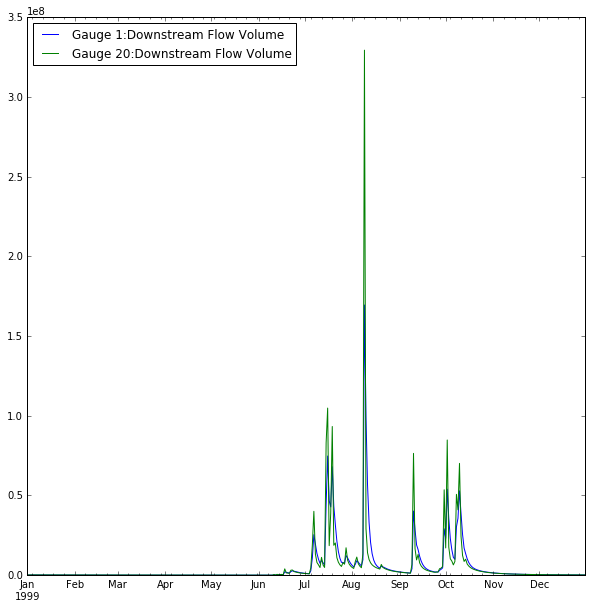

In [52]:
downstream[['Gauge 1:Downstream Flow Volume','Gauge 20:Downstream Flow Volume']].plot(figsize=(10,10))

If you'd like to change and rerun this example, the following code block can be used to delete all the existing nodes. (Or, just start a new project in Source)

In [53]:
#nodes = v2.network()['features'].find_by_feature_type('node')._all_values('name')
#for n in nodes:
#    v2.model.node.remove(n)

## Conclusion

This session has looked at structural modifications of Source using Veneer, veneer-py and the use of IronPython scripts that run within Source.

Writing IronPython scripts requires a knowledge of internal Source data structures, but there is a growing collection of helper functions, under the `v.model` namespace to assist.